In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.fft import fft
import scipy.signal as signal
from math import log10

**SE OBTIENE EL DATASET**




In [17]:
with np.load('dataset_filt.npz') as data:
    ecg = {key: data[key] for key in data.keys()}
print(ecg)
data = ecg['data'].flatten()[0:20000]
fs = 1000


{'data': array([[510.35, 510.35, 510.35, ..., 514.85, 514.14, 513.43],
       [507.28, 507.28, 507.28, ..., 514.06, 513.3 , 512.53],
       [507.19, 507.19, 507.19, ..., 509.15, 508.26, 507.27],
       ...,
       [503.69, 503.69, 503.69, ..., 580.65, 579.61, 578.84],
       [503.32, 503.32, 503.32, ..., 559.34, 559.46, 559.04],
       [507.15, 507.15, 507.15, ..., 543.15, 544.54, 545.99]]), 'target': array([0, 0, 0, ..., 2, 2, 2]), 'target_names': array(['basal', 'respiration', 'post-exercise'], dtype='<U13')}


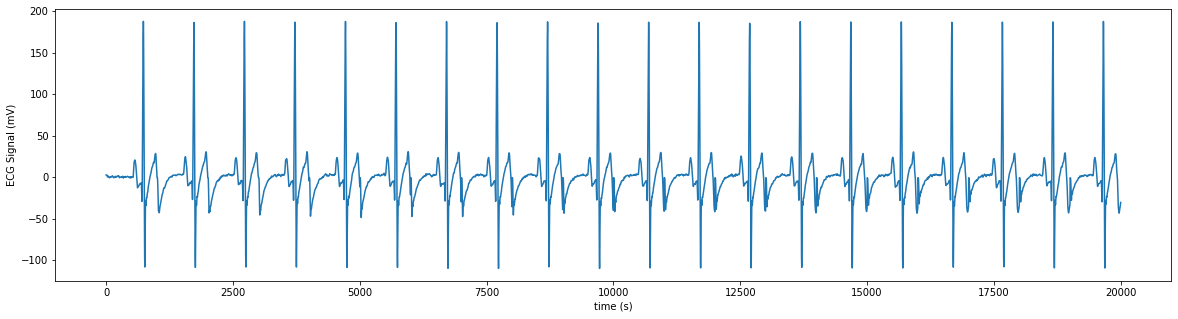

In [28]:
# A numpy
n = np.arange(len(data))
t = n/fs
data = data - np.mean(data)
plt.figure(figsize=(20,5))
plt.plot(data)
plt.ylabel('ECG Signal (mV)')
plt.xlabel('time (s)')
plt.show()

**SE ANALIZA LA SEÑAL EN FRECUENCIA**

Conociendo los datos de adquisición de la señal, analicemos ahora el espectro de Fourier.

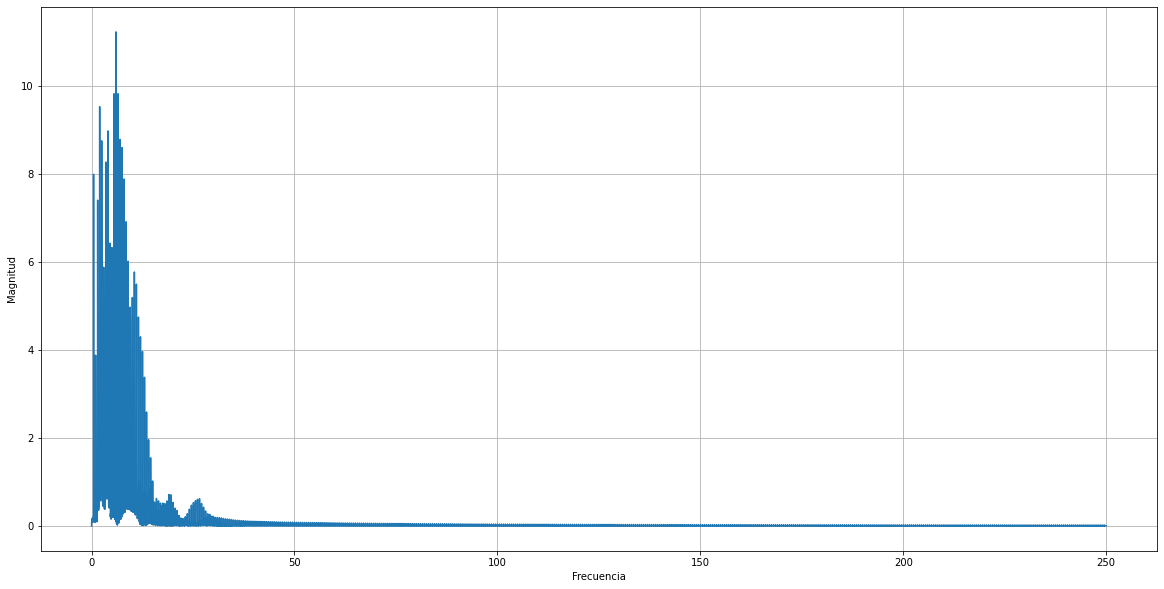

In [29]:
# Analizar el Fourier
ecg_senal = data
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
T = 0.002
N = len(ecg_senal)
yf = fft(ecg_senal)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()

En el gráfico anterior, existe un ruido en 50 Hz y armónicos en 150 HZ. Por lo tanto, se debe filtrar.

Se propone utilizar filtros digitales Notch



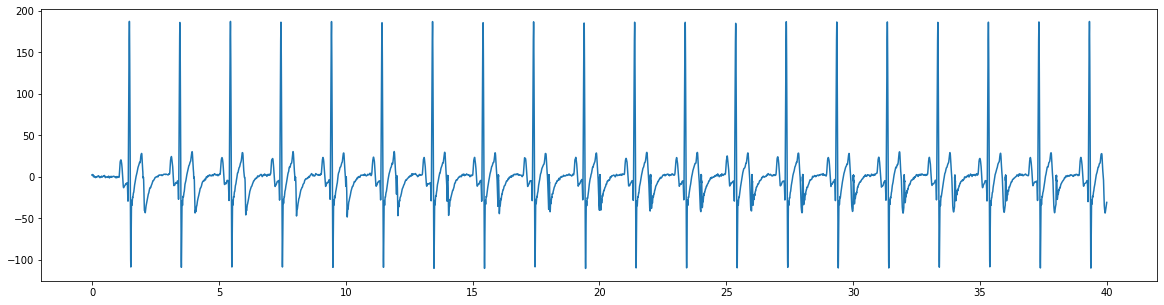

In [30]:
# Utilizar filtros Notch para quitar frecuencias que hagan ruido
from scipy.signal import iirnotch, lfilter
fs = 1/T  # Frecuencia de muestreo (Hz)
f0 = 50.0  # Frecuencia que queremos filtrar (Hz)
Q = 20.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b, a, ecg_senal)
y = lfilter(b, a, y)
fs = 1/T  # Frecuencia de muestreo (Hz)
f0 = 150.0  # Frecuencia que queremos filtrar (Hz)
Q = 7.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b,a,y)
plt.figure(figsize=(20,5))
#plt.xlim(0,200)
plt.plot(t,y)
plt.show()

Regresamos a verificar las atenuaciones de los filtros en frecuencia

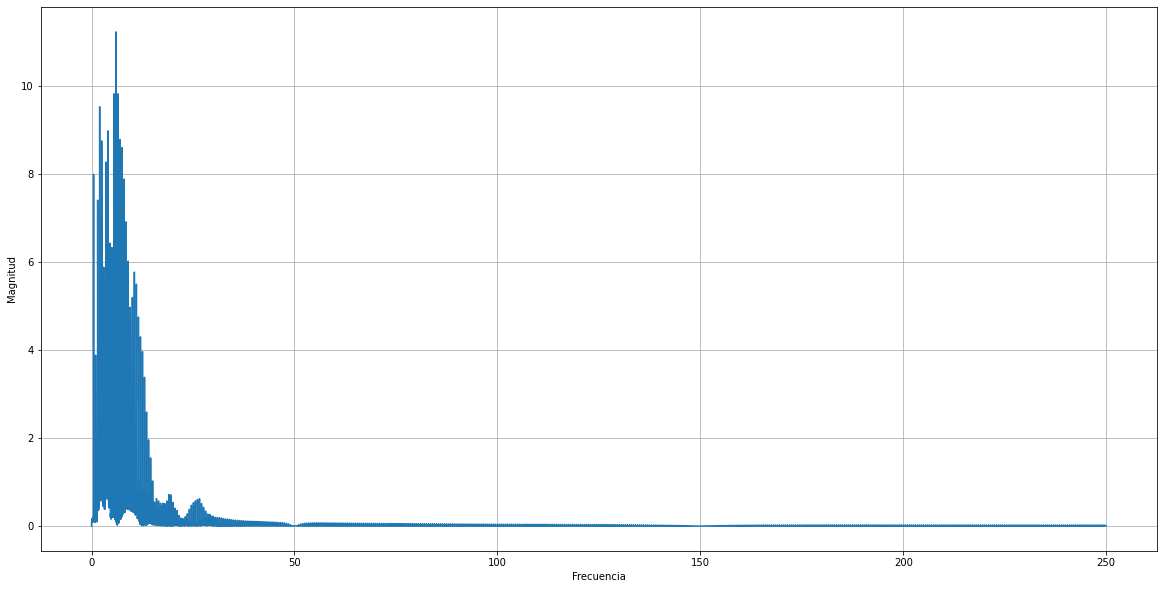

In [31]:
# Analisis de Fourier de los filtros
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
T = 0.002
N = len(y)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()
ecg_signal = y

**FILTRADO DE PASA BANDA**

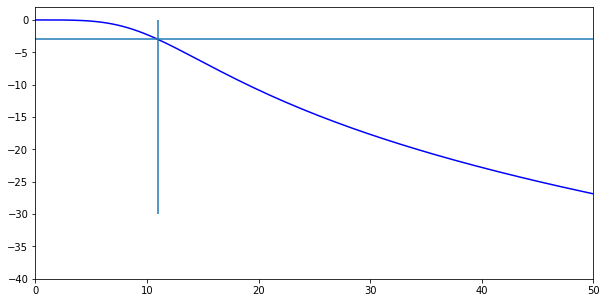

In [32]:
from scipy.signal import freqz, iirdesign, iirfilter, find_peaks
# 2. filtro pasa banda
# Sub filtro pasa bajo
b, a = iirfilter(2, 11.0, btype='lowpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(11, -30, 0)
plt.ylim(-40,2)
plt.show()

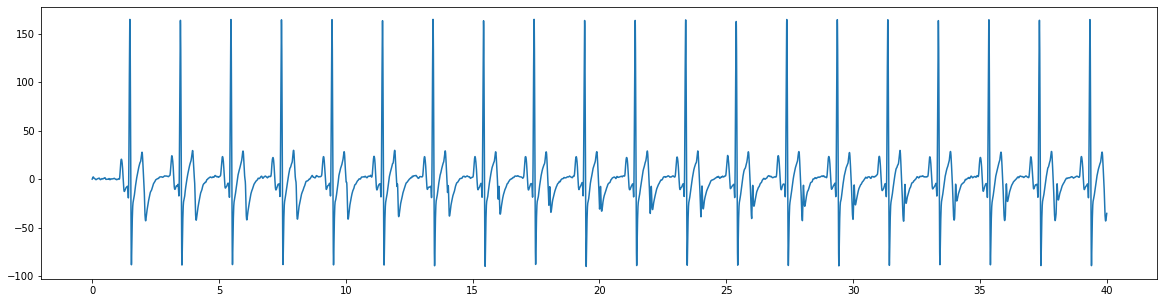

In [33]:
fpb_signal = lfilter(b, a, ecg_signal)
plt.figure(figsize=(20,5))
plt.plot(t,fpb_signal)
plt.show()

**FILTRO PASA ALTO**

C:\Users\eduma\AppData\Local\Temp/ipykernel_4704/3387080172.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


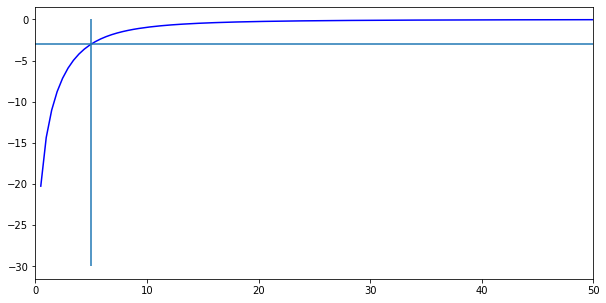

In [34]:
b, a = iirfilter(1, 5.0, btype='highpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(5, -30, 0)
plt.show()


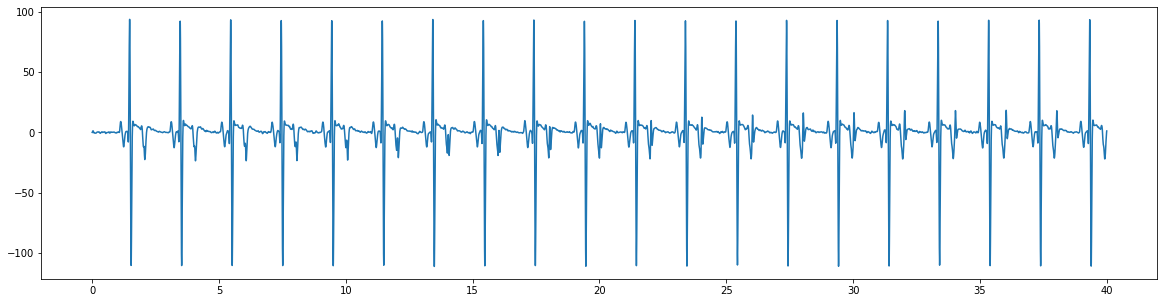

In [35]:
fpa_signal = lfilter(b, a, fpb_signal)
plt.figure(figsize=(20,5))
plt.plot(t,fpa_signal)
plt.show()

**OPERADOR DERIVATIVO**

En el artículo nos dan la siguiente función que describe al operador:

y[n]=(1/8)(−x[n−2]−2x[n−1]+2x[n+1]+x[n+2])

Para que esta ecuación pueda ser utilizada necesitamos encuadrarla en un rango de  [0,+∞]  haciendo que  n=+2  entonces tenemos:

y[n]=(1/8)(−x[n]−2x[n+1]+2x[n+3]+x[n+4]) 

Por lo tanto:

b=[−1,−2,0,2,1]

C:\Users\eduma\AppData\Local\Temp/ipykernel_4704/73101146.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


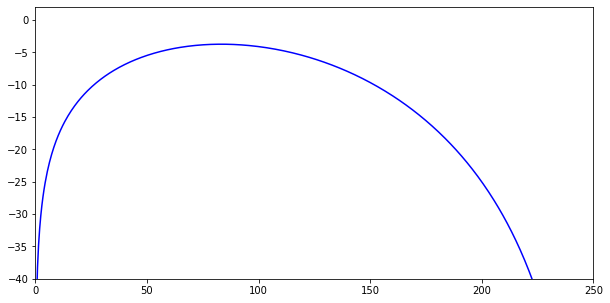

In [36]:
# Filtro derivativo
b = np.array([-1, -2, 0, 2, 1])
b = (1/8)*b
w, h = freqz(b, 1, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.xlim(0,250)
plt.ylim(-40,2)
plt.show()

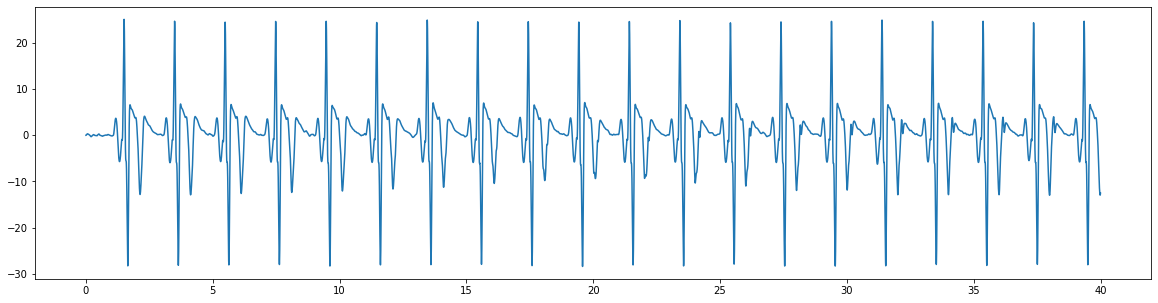

In [47]:
fd_signal = lfilter(b, 1, fpa_signal)
plt.figure(figsize=(20,5))
plt.plot(t,fd_signal)
plt.show()

**OPERADOR CUADRÁTICO**

Este operador solo tiene como función elevar al cuadrado los valores de la señal.

y[n]=x^2[n]

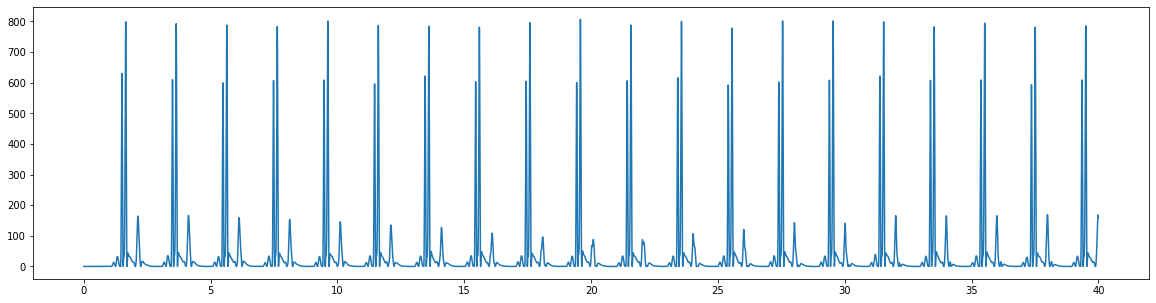

In [49]:
# Filtro cuadrado
f_sq = fd_signal**2
plt.figure(figsize=(20,5))
plt.plot(t, f_sq)
plt.show()

**OPERADOR MOVING WINDOW INTEGRATION**

Este operador tiene como función extraer ciertas características de la onda.

y[n]=(1/N)(x[n−(N−1)]+x[n−(N−2)]+..+x[n])

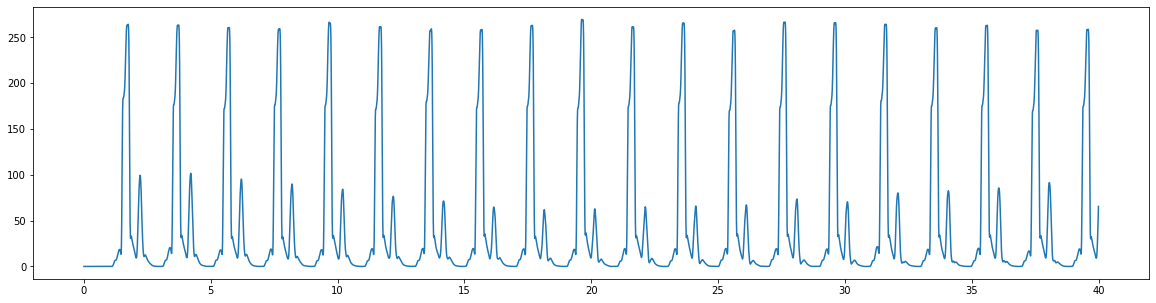

In [50]:
# Moving-Window Integration
N = 75
b = np.ones(N-1)
b = (1/N)*b
fi_signal = lfilter(b, 1, f_sq)
plt.figure(figsize=(20,5))
plt.plot(t,fi_signal)
plt.show()

Colocando marcadores en los picos

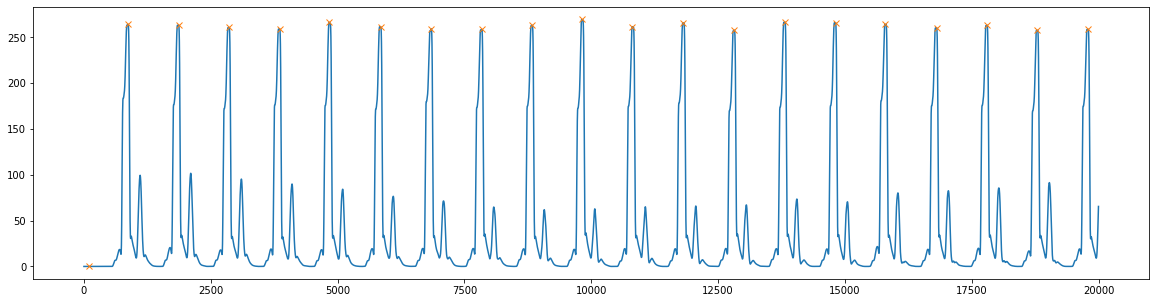

In [59]:
# Fiducial Marks
peaks, _ = find_peaks(fi_signal, distance=500)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
plt.plot(peaks, fi_signal[peaks], "x")
plt.show()

**ANÁLISIS DE THRESHOLD**

El valor del umbral de pico R de entrada es  107.87167284948646
El valor del umbral de ruido de entrada es  150.00194986241272


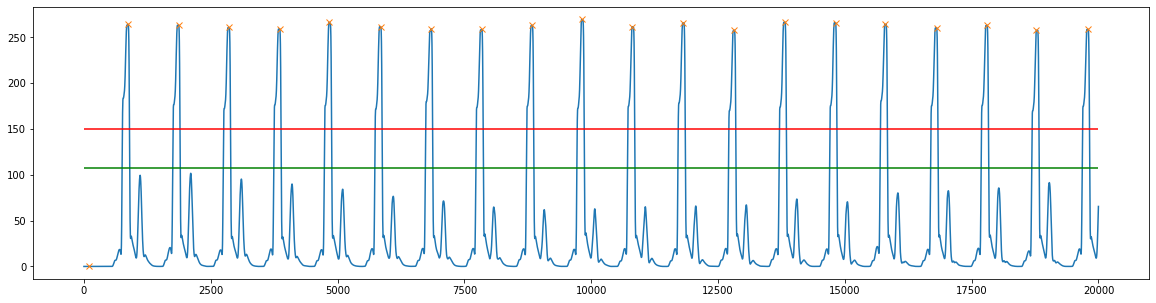

In [71]:
# Training Part to set Threshold I1 and Threshold I2
# Para las primeras muestras en 2 segundos
# Para efectos del ejercicio vamos a analizar toda la señal
f_samples = len(peaks)
th_I1 = np.max(fi_signal[peaks[:f_samples]])*0.4
th_I2 = 0.6*np.mean(fi_signal[peaks[:f_samples]])
print ("El valor del umbral de pico R de entrada es ", th_I1)
print ("El valor del umbral de ruido de entrada es ", th_I2)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
#plt.xlim(50,1000)
plt.plot(peaks, fi_signal[peaks], "x")
plt.hlines(th_I1, 0, len(fi_signal), colors='green')
plt.hlines(th_I2, 0, len(fi_signal), colors='red')
plt.show()

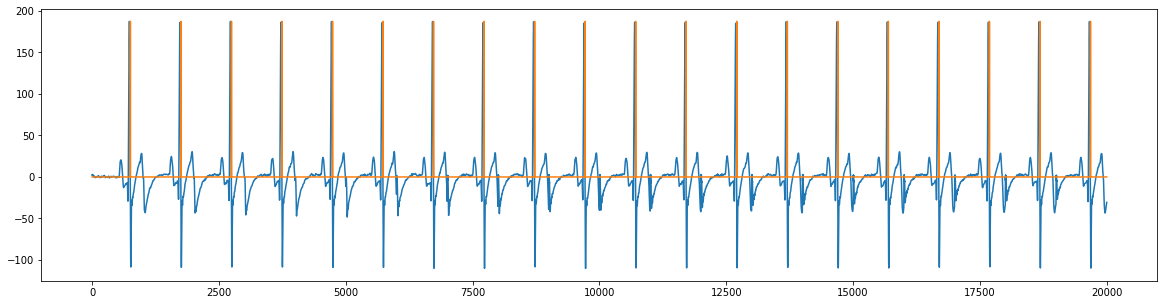

In [73]:
end_qrs = fi_signal > th_I1
roll_qrs_r = np.roll(end_qrs, 1)
roll_qrs_l = np.roll(end_qrs, -1)
end_qrs = np.logical_xor(end_qrs ,roll_qrs_r)
end_qrs = np.logical_and(end_qrs ,roll_qrs_l)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.plot(end_qrs*np.max(ecg_signal))
plt.show()

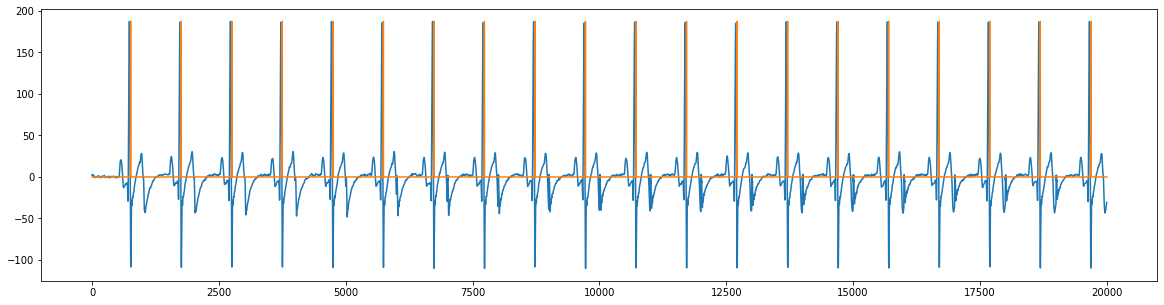

In [74]:
start_qrs = fi_signal < th_I2
roll_qrs_l = np.roll(start_qrs, -1)
roll_qrs_r = np.roll(start_qrs, 1)
start_qrs = np.logical_xor(start_qrs ,roll_qrs_l)
start_qrs = np.logical_and(start_qrs ,roll_qrs_r)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.plot(start_qrs*np.max(ecg_signal))
plt.show()

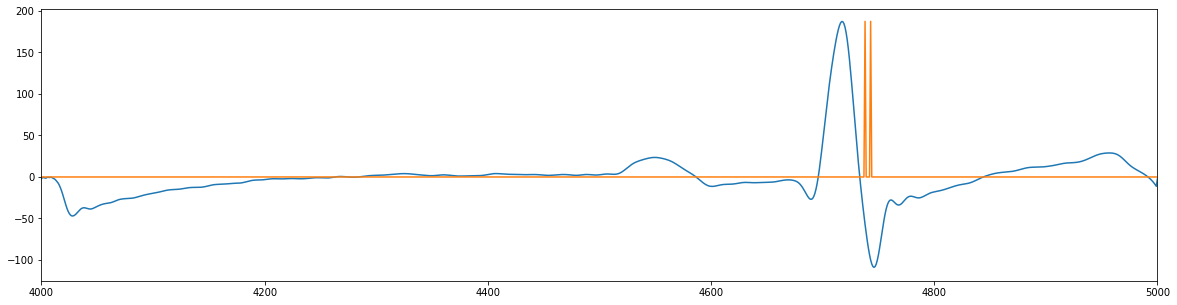

In [75]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.xlim(4000,5000)
plt.plot(ecg_signal)
plt.plot(qrs*np.max(ecg_signal))
plt.show()


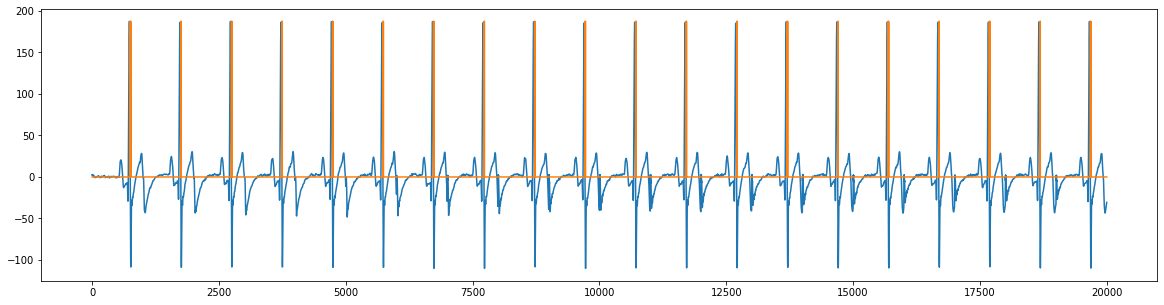

In [76]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.plot(qrs*np.max(ecg_signal))
plt.show()